In [1]:
##################################
#
# Implementation of the Linear Logic Recurrent Neural Network (LLRNN)
#
# The architecture is a modified RNN, see the paper "Linear logic and recurrent neural networks".
# Our inputs are sequences of symbols taken from an alphabet of size num_classes. The length
# of the sequences is N. Our outputs are also sequences of length N from the same alphabet.

################
# GLOBAL FLAGS #
################

use_model             = 'ntm' # ntm, pattern_ntm, pattern_ntm_alt
task                  = 'copy' # copy, repeat copy, pattern
epoch                 = 10 # number of training epochs, default to 200
num_classes           = 10 # number of symbols, INCLUDING initial and terminal symbols
N                     = 30 # length of input sequences for training, default to 20, INCLUDING initial and terminal symbols
Ntest                 = 35 # length of sequences for testing, default to N, INCLUDING initial and terminal symbols
batch_size            = 500 # default to 500 (too large does not fit on GPUs)
controller_state_size = 100 # dimension of the internal state space of the controller, default 100
memory_address_size   = 128 # number of memory locations, default 20
memory_content_size   = 20 # size of vector stored at a memory location, default 5
powers_ring1          = [0,-1,1] # powers of R used on ring 1, default [0,-1,1]
powers_ring2          = [0,-1,1] # powers of R used on ring 2, default [0,-1,1]
LOG_DIR               = '/tmp/log' # default /tmp/log
num_training          = 10000 # default to int(training_percent * (num_classes-2)**N)
num_test              = num_training
init_symbol           = num_classes - 2
term_symbol           = num_classes - 1

##########
# NOTES
#
# 1. Always put the zero power first in powers_ring since the code assumes this is there
# 2. The initial and terminal symbols are always from the end of the list of symbols, so they
# are respectively num_classes - 2 and num_classes - 1. So the number of symbols which are
# not initial or terminal is num_classes - 2

In [2]:
%matplotlib notebook

# The next three lines are recommend by TF
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import collections
import six
import math
import time
import random

from tensorflow.python.ops.rnn_cell_impl import _RNNCell as RNNCell
from tensorflow.python.ops import array_ops
from tensorflow.python.ops import init_ops
from tensorflow.python.ops.math_ops import sigmoid
from tensorflow.python.ops.math_ops import tanh

# Our libraries
import ntm
import seqhelper
import learnfuncs

In [3]:
#######################
# SETUP TASKS
#
# Our sequences are of one-hot vectors, which we interpret as follows:
#
# [1.0, 0.0, 0.0] = 0
# [0.0, 1.0, 0.0] = 1
# [0.0, 0.0, 1.0] = 2 etc
#
# We write our sequences and functions referring to sequences of integers,
# and then convert to one-hot vectors for integration with TF.

# Below N_out and Ntest_out are the lengths of the outputs in both the training
# and testing regimes respectively. Since outputs do not include the initial and terminal
# symbols, these default to N - 2 and Ntest - 2 respectively.

###########
# COPY TASK
if( task == 'copy' ):
    func_to_learn = learnfuncs.f_identity
    N_out = N - 2
    Ntest_out = Ntest - 2

##################
# REPEAT COPY TASK
# put n zeros before the 1, for a copy task with n + 1 copies
if( task == 'repeat copy' ):
    pattern = [0,1]
    func_to_learn = lambda s: learnfuncs.f_repetitionpattern(s,pattern)
    N_out = 2 * (N - 2)
    Ntest_out = 2 * (Ntest - 2)

##############
# PATTERN TASK
if( task == 'pattern' ):
    pattern = [1,0,0,2,0]
    func_to_learn = lambda s: learnfuncs.f_repetitionpattern(s,pattern)
    N_out = 2 * (N - 2)
    Ntest_out = 2 * (Ntest - 2)

# Give an example input/output pair
a = [random.randint(0,num_classes-3) for i in range(N)]
fa = func_to_learn(a)

print("Under the chosen function, the sequence")
print(a)
print("is mapped to")
print(fa)

Under the chosen function, the sequence
[6, 4, 5, 0, 2, 4, 0, 4, 4, 2, 7, 7, 4, 5, 7, 4, 5, 2, 5, 7, 2, 1, 7, 5, 3, 6, 7, 6, 3, 5]
is mapped to
[6, 4, 5, 0, 2, 4, 0, 4, 4, 2, 7, 7, 4, 5, 7, 4, 5, 2, 5, 7, 2, 1, 7, 5, 3, 6, 7, 6, 3, 5]


In [4]:
####################
# INITIALISE STATE #
####################

one_hots = seqhelper.one_hot_vectors(num_classes)
input_size = num_classes # dimension of the input space I
state_size = 0

#####
# NTM

def init_state_ntm(batch_size, css, mas, mcs):
    state_size = controller_state_size + 2*memory_address_size + memory_address_size * memory_content_size
    
    ra = [0.0]*mas
    ra[0] = 1.0
    batch_address = np.zeros([batch_size,mas]) + ra
    
    # DEBUG at the moment the read and write addresses are not distributions, i.e. they do not
    # sum to 1, but after one step the gamma sharpening will normalise them. We should probably start
    # with things that sum to 1, though.
    init_controller_state = tf.truncated_normal([batch_size, css], 0.0, 1e-6, dtype=tf.float32)
    #init_controller_state = tf.get_variable("init_ccs", shape=[batch_size, controller_state_size], initializer=tf.contrib.layers.xavier_initializer())
    
    init_read_address = tf.constant(batch_address,dtype=tf.float32,shape=[batch_size,mas]) #+ \
                       #tf.random_uniform([batch_size, mas], 0.0, 1e-6)
    
    init_write_address = tf.constant(batch_address,dtype=tf.float32,shape=[batch_size,mas]) #+ \
                       #tf.random_uniform([batch_size, mas], 0.0, 1e-6)
    
    init_memory = tf.truncated_normal([batch_size, mas*mcs], 0.0, 1e-6, dtype=tf.float32)
    #init_memory = tf.get_variable("init_mem", shape=[batch_size, memory_address_size*memory_content_size], initializer=tf.contrib.layers.xavier_initializer())
    
    state = tf.concat([init_controller_state,init_read_address,init_write_address,init_memory],1)
    return state_size, state


if( use_model == 'ntm' ):
    state_size, state = init_state_ntm(batch_size, controller_state_size,
                                  memory_address_size, memory_content_size)
    
    cell = ntm.NTM(state_size,input_size,controller_state_size,memory_address_size,memory_content_size, powers_ring1)
        
#############
# PATTERN NTM
if( use_model == 'pattern_ntm' ):
    state_size = controller_state_size + 4*memory_address_size + \
                memory_address_size * memory_content_size + \
                memory_address_size * len(powers_ring1)

    cell = ntm.PatternNTM(state_size,input_size,controller_state_size,
                          memory_address_size,memory_content_size, powers_ring1, powers_ring2)
    
    state = tf.truncated_normal([batch_size, state_size], 0.0, 0.01, dtype=tf.float32)
    
#################
# PATTERN NTM ALT
if( use_model == 'pattern_ntm_alt' ):
    state_size = controller_state_size + 4*memory_address_size + \
                memory_address_size * memory_content_size + \
                memory_address_size * len(powers_ring1)

    cell = ntm.PatternNTM_alt(state_size,input_size,controller_state_size,
                          memory_address_size,memory_content_size, powers_ring1, powers_ring2)
    
    state = tf.truncated_normal([batch_size, state_size], 0.0, 0.01, dtype=tf.float32)


In [5]:
################
# DEFINE MODEL #
################

inputs = [tf.placeholder(tf.float32, [None,input_size]) for _ in range(N + N_out)]
targets = [tf.placeholder(tf.float32, [None,input_size]) for _ in range(N + N_out)]

# Used in order to flag that we share weights across iterations.
# Note that the training and test phases use all the same weights.
reuse = False

# Set up training graph
read_addresses = []
write_addresses = []
gamma_writes = []
gamma_reads = []
ss = []
rnn_outputs = []
    
for i in range(N + N_out):
    # Logging
    h0, curr_read, curr_write, _ = tf.split(state, [controller_state_size,
                                                    memory_address_size,
                                                    memory_address_size,-1], 1)
    
    #### RUN MODEL ####
    output, state = cell(inputs[i],state,'NTM',reuse)
    rnn_outputs.append(output)
    ###################
    
    # More logging
    read_addresses.append(curr_read[0,:])
    write_addresses.append(curr_write[0,:])
    
    with tf.variable_scope("NTM",reuse=True):
        W_gamma_write = tf.get_variable("W_gamma_write", [controller_state_size,1])
        B_gamma_write = tf.get_variable("B_gamma_write", [])
        gamma_write = 1.0 + tf.nn.relu(tf.matmul(h0,W_gamma_write) + B_gamma_write) # shape [batch_size,1]
        
        W_gamma_read = tf.get_variable("W_gamma_read", [controller_state_size,1])
        B_gamma_read = tf.get_variable("B_gamma_read", [])
        gamma_read = 1.0 + tf.nn.relu(tf.matmul(h0,W_gamma_read) + B_gamma_read) # shape [batch_size,1]
        
        W_s = tf.get_variable("W_s", [controller_state_size,len(powers_ring1)])
        B_s = tf.get_variable("B_s", [len(powers_ring1)])
        s = tf.nn.softmax(tf.matmul(h0,W_s) + B_s) # shape [batch_size,len(powers)]

    gamma_writes.append(gamma_write[0,:])
    gamma_reads.append(gamma_read[0,:])
    ss.append(s[0,:])
    reuse = True

# Final fully connected layer
with tf.variable_scope("final_layer"):
    E = tf.get_variable("E",[controller_state_size,input_size])
    F = tf.get_variable("F",[input_size],initializer=init_ops.constant_initializer(0.0))

# prediction is a length N list of tensors of shape [None,input_size], where
# the jth row of prediction[d] is, for the jth input sequence in the batch,
# the probability distribution over symbols for the output symbol in position d.
# Note: we use log_softmax to avoid precision issues with floats causing log(0) to create NaNs
logits = [tf.matmul(rnn_output, E) + F for rnn_output in rnn_outputs]
prediction = [tf.nn.log_softmax(logit) for logit in logits] 
ce = [tf.reduce_sum(targets[i] * prediction[i]) for i in range(N + N_out)]
cross_entropy = -tf.add_n(ce)
                    
# optimizer = tf.train.AdamOptimizer(1e-4)
optimizer = tf.train.RMSPropOptimizer(1e-4,decay=0.9,momentum=0.9)
minimize = optimizer.minimize(cross_entropy)

mistakes = [tf.not_equal(tf.argmax(targets[i], 1), tf.argmax(prediction[i], 1)) for i in range(N + N_out)]
errors = [tf.reduce_mean(tf.cast(m, tf.float32)) for m in mistakes]

# Summaries
mean_error = tf.scalar_mul(np.true_divide(1,N + N_out), tf.add_n(errors))
tf.summary.scalar('error', mean_error)

# Initialise the model
init_op = tf.global_variables_initializer()
sess = tf.Session()
sess.run(init_op)

merged_summaries = tf.summary.merge_all()
file_writer = tf.summary.FileWriter(LOG_DIR, sess.graph)

[<tf.Tensor 'gradients/NTM_114/split_grad/concat:0' shape=(500, 2916) dtype=float32>, None, None]
[<tf.Tensor 'gradients/NTM_112/split_grad/concat:0' shape=(500, 2916) dtype=float32>, None, None]
[<tf.Tensor 'gradients/NTM_110/split_grad/concat:0' shape=(500, 2916) dtype=float32>, None, None]
[<tf.Tensor 'gradients/NTM_108/split_grad/concat:0' shape=(500, 2916) dtype=float32>, None, None]
[<tf.Tensor 'gradients/NTM_106/split_grad/concat:0' shape=(500, 2916) dtype=float32>, None, None]
[<tf.Tensor 'gradients/NTM_104/split_grad/concat:0' shape=(500, 2916) dtype=float32>, None, None]
[<tf.Tensor 'gradients/NTM_102/split_grad/concat:0' shape=(500, 2916) dtype=float32>, None, None]
[<tf.Tensor 'gradients/NTM_100/split_grad/concat:0' shape=(500, 2916) dtype=float32>, None, None]
[<tf.Tensor 'gradients/NTM_98/split_grad/concat:0' shape=(500, 2916) dtype=float32>, None, None]
[<tf.Tensor 'gradients/NTM_96/split_grad/concat:0' shape=(500, 2916) dtype=float32>, None, None]
[<tf.Tensor 'gradients

Step 0 argmax [0] w-gamma [ 1.] w-rotations [ 0.33333293  0.3333331   0.333334  ]
Step 1 argmax [1] w-gamma [ 1.15123248] w-rotations [ 0.41669911  0.31689817  0.26640278]
Step 2 argmax [0] w-gamma [ 1.09758079] w-rotations [ 0.29550636  0.35048735  0.35400632]
Step 3 argmax [0] w-gamma [ 1.07632554] w-rotations [ 0.39849529  0.36547568  0.23602897]
Step 4 argmax [0] w-gamma [ 1.] w-rotations [ 0.51616681  0.27489918  0.20893398]
Step 5 argmax [0] w-gamma [ 1.40035868] w-rotations [ 0.29127997  0.33310595  0.37561408]
Step 6 argmax [0] w-gamma [ 1.33295178] w-rotations [ 0.41339353  0.29752594  0.2890805 ]
Step 7 argmax [0] w-gamma [ 1.12388277] w-rotations [ 0.26951197  0.4488149   0.2816731 ]
Step 8 argmax [0] w-gamma [ 1.] w-rotations [ 0.36873913  0.23334233  0.39791861]
Step 9 argmax [0] w-gamma [ 1.] w-rotations [ 0.26787043  0.46400762  0.26812193]
Step 10 argmax [0] w-gamma [ 1.] w-rotations [ 0.40920699  0.33955619  0.25123686]
Step 11 argmax [127] w-gamma [ 1.] w-rotations [ 

<IPython.core.display.Javascript object>


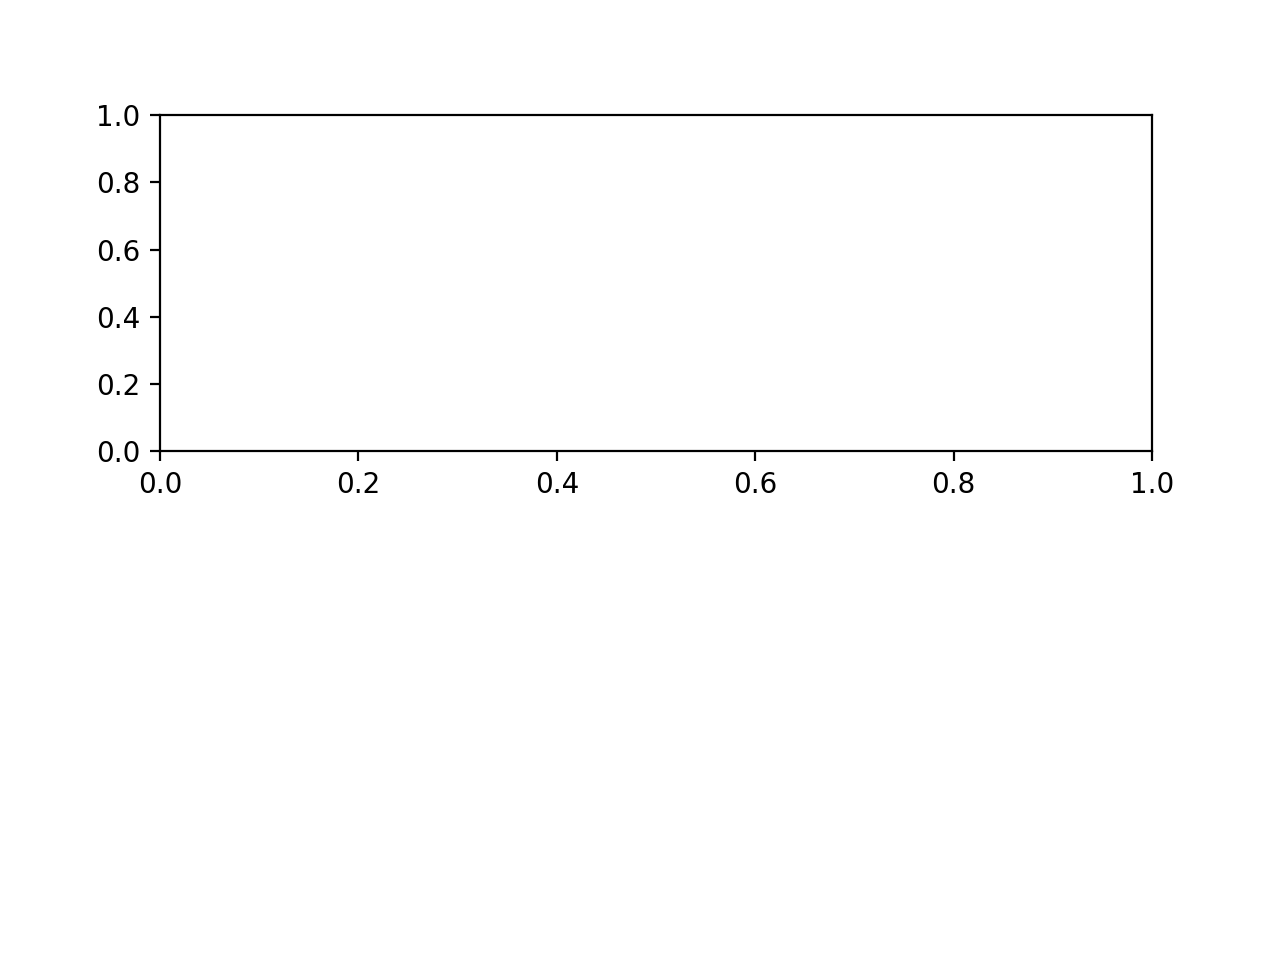

AttributeError: 'AxesSubplot' object has no attribute 'xlabel'

In [6]:
############
# TRAINING #
############

random.seed()

pre_train_time = time.time()

# Training
no_of_batches = int(num_training/batch_size)

# An annoying thing here is that we cannot use a list as a key in a 
# dictionary. The workaround we found on StackOverflow here:
# http://stackoverflow.com/questions/33684657/issue-feeding-a-list-into-feed-dict-in-tensorflow)

# epoch is a global var
for i in range(epoch):
    for j in range(no_of_batches):
        inp = []
        out = []

        # We sample each batch on the fly from the set of all sequences
        for z in range(batch_size):
            # construct a sequence from 0,...,num_classes - 3 then append initial and
            # terminal symbols to make a sequence of total length N + N_out.
            seq_length = random.randint(3,N)
            a = [random.randint(0,num_classes-3) for k in range(seq_length-2)]
            a = [init_symbol] + a + [term_symbol] + [term_symbol for k in range(N+N_out-seq_length)] # length N + N_out
            fa = [init_symbol for k in range(N+N_out-seq_length+2)] + func_to_learn(a) # length N + N_out
            a_onehot = [one_hots[e] for e in a]
            fa_onehot = [one_hots[e] for e in fa]
            inp.append(np.array(a_onehot))
            out.append(np.array(fa_onehot))        
        
        # Note we have to feed all the input nodes
        feed_dict = {}
        for d in range(N + N_out):
            in_node = inputs[d]
            # inp has dimensions [batch_size, N, num_classes] and we want to extract
            # the 2D Tensor of shape [batch_size, num_classes] obtained by setting the
            # second coordinate to d
            ti = []
            for k in range(batch_size):
                ti.append(inp[k][d])
            feed_dict[in_node] = np.array(ti)

        for d in range(N + N_out):
            out_node = targets[d]
            to = []
            for k in range(batch_size):
                to.append(out[k][d])
            feed_dict[out_node] = np.array(to)
        
        # for the first batch in an epoch, we have some logging
        if( j == 0 and i % 25 == 0 ):
            ss_val, gamma_reads_val, gamma_writes_val, read_addresses_val, write_addresses_val = sess.run([ss, gamma_reads,gamma_writes,read_addresses,write_addresses],feed_dict)
    
            s = 0
            for r in range(len(write_addresses_val)):
                print("Step " + str(s) + " argmax [" + str(write_addresses_val[r].argmax()) + "]" + 
                      " w-gamma " + str(gamma_writes_val[r]) + 
                      " w-rotations " + str(ss_val[r]))
                if( r == len(write_addresses_val) - 1 ):
                    print("Write address -")
                    print(write_addresses_val[r])               
                s = s + 1
        
        ##### Do gradient descent #####
        summary,_ = sess.run([merged_summaries,minimize], feed_dict)
        ########
        
        # Write out TensorBoard logs
        file_writer.add_summary(summary)
    current_mean = np.mean(sess.run(errors, feed_dict))
    
    # Print the mean error of the final batch in the epoch
    print("Epoch - " + str(i+1) + " error - " + str(current_mean))
    
# Matplotlib
plt.xlabel('Memory location')
plt.ylabel('Time')
plt.title('Write address')
plt.imshow(np.stack(write_addresses_val), cmap='bone', interpolation='nearest')
plt.show()

# Write out variables to disk
saver = tf.train.Saver()
save_path = saver.save(sess,"/tmp/model.ckpt")
sess.close()

print("")
print("It took", time.time() - pre_train_time, "seconds to train.")

In [ ]:
###########
# TESTING #
###########

# Restore the weights from training
sess = tf.Session()
saver.restore(sess,save_path)

inputs_test = [tf.placeholder(tf.float32, [None,input_size]) for _ in range(Ntest + Ntest_out)]
targets_test = [tf.placeholder(tf.float32, [None,input_size]) for _ in range(Ntest + Ntest_out)]

if( use_model == 'ntm' ):
    state_size, state = init_state_ntm(batch_size, controller_state_size,
                                  memory_address_size, memory_content_size)
    
    cell = ntm.NTM(state_size,input_size,controller_state_size,memory_address_size,memory_content_size, powers_ring1) 

# Set up test graph
rnn_outputs_test = []
reuse = True
for i in range(Ntest + Ntest_out):
    output, state = cell(inputs_test[i],state,'NTM',reuse)
    rnn_outputs_test.append(output)

with tf.variable_scope("final_layer",reuse=True):
    E = tf.get_variable("E",[controller_state_size,input_size])
    F = tf.get_variable("F",[input_size])

logits_test = [tf.matmul(rnn_output, E) + F for rnn_output in rnn_outputs_test]
prediction_test = [tf.nn.softmax(logit) for logit in logits_test] 
mistakes_test = [tf.not_equal(tf.argmax(targets_test[i], 1), tf.argmax(prediction_test[i], 1)) for i in range(Ntest + Ntest_out)]
errors_test = [tf.reduce_mean(tf.cast(m, tf.float32)) for m in mistakes_test]

#### RUN TEST ####

no_of_batches = int(num_test/batch_size)

error_means = []
for j in range(no_of_batches):
    inp = []
    out = []

    # We sample each batch on the fly from the set of all sequences
    for z in range(batch_size):
        a = [random.randint(0,num_classes-3) for k in range(Ntest-2)]
        a = [init_symbol] + a + [term_symbol] + [term_symbol for k in range(Ntest_out)] # length N + N_out
        fa = [init_symbol for k in range(Ntest)] + func_to_learn(a) # length N + N_out
        a_onehot = [one_hots[e] for e in a]
        fa_onehot = [one_hots[e] for e in fa]
        inp.append(np.array(a_onehot))
        out.append(np.array(fa_onehot))        
        
    feed_dict = {}
    for d in range(Ntest + Ntest_out):
        in_node = inputs_test[d]
        ti = []
        for k in range(batch_size):
            ti.append(inp[k][d])
        feed_dict[in_node] = np.array(ti)

    for d in range(Ntest + Ntest_out):
        out_node = targets_test[d]
        to = []
        for k in range(batch_size):
            to.append(out[k][d])
        feed_dict[out_node] = np.array(to)
            
    current_mean = np.mean(sess.run(errors_test, feed_dict))
    error_means.append(current_mean)
    print("Batch - " + str(j+1) + ", Mean error - " + str(current_mean))

final_error = np.mean(error_means)

print("")        
print("###########")
print("# Summary #")
print("###########")
print("")
print("model         - " + use_model)
print("task name     - " + task)
print("num_classes   - " + str(num_classes))
print("N             - " + str(N))
print("N_out         - " + str(N_out))
print("Ntest         - " + str(Ntest))
print("Ntest_out     - " + str(Ntest_out))
print("ring 1 powers - " + str(powers_ring1))
print("ring 2 powers - " + str(powers_ring2))
print("# epochs      - " + str(epoch))
print("# weights     - " + str(ntm.count_number_trainable_params()))
print("(css,mas,mcs) - (" + str(controller_state_size) + "," + str(memory_address_size) + "," + str(memory_content_size) + ")")
#print("train percent - " + str(training_percent))
print("num_training  - " + str(num_training) + "/" + str(num_classes**N))
print("num_test      - " + str(num_test) + "/" + str(num_classes**N))
print("")
print("")
print("error         - " + str(final_error))
sess.close()